# Dark Sky Positions direct from Catalogue

In [55]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.coordinates import SkyCoord

import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np
from scipy.spatial import distance_matrix

from dl import queryClient as qc
import pandas as pd

In [8]:
# timer function
import functools
import time

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(elapsed_time)
        return value
    return wrapper_timer


## Querying tractor catalogue for one degree squares

In [ ]:
@timer
def query_tractor(ra, dec, query_dist=1.0):
    """Queries the Astro Data Lab for the ra, dec and mag_g of the objects within a square of side length (dist).     
    dist is in degrees
    """
    # Bounds of the square we are querying objects for
    ra_min=ra
    ra_max = ra + query_dist
    dec_min=dec
    dec_max = dec + query_dist

    query = f"""
    SELECT ra, dec, mag_g,mag_r,mag_i,mag_z
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND (mag_g<=21 AND mag_g>=16
        OR mag_r<=21 AND mag_r>=16
        OR mag_i<=21 AND mag_i>=16
        OR mag_z<=21 AND mag_z>=16)       
    """
    
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info

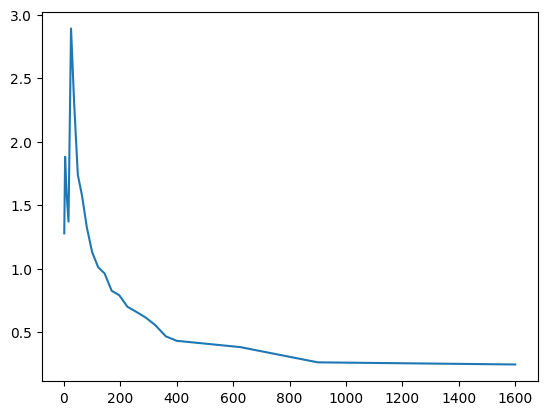

In [6]:
x = [1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 625, 900, 1600]
y = [1.2789743749999616, 7.527789000000041/4, 14.455102375000024/9, 21.94977908300001/16, 72.33531233299993/25, 83.05894341699991/36, 85.35484112500001/49, 100.86192695799991/64, 107.4080237500001/81, 113.01894195800003/100, 122.56287062500019/121, 138.68802762500013/144, 139.764082208/169, 155.17113345799999/196, 157.64259362500002/225, 169.22000945800005/256, 178.27083341599996/289, 179.95430566699997/324, 168.81875749999972/361, 172.9240558749998/400, 239.27568062499995/625, 236.5007538750001/900, 393.484322875/1600]

plt.plot(x,y)

In [53]:
brick_info = query_tractor(0,-30,1)
brick_info

9.08773149999979


,ra,dec,mag_g,mag_r,mag_i,mag_z
0,0.052292,-29.990549,20.576283,19.208673,NaN,17.813751
1,0.171944,-29.967732,18.637722,17.318207,NaN,16.467838
2,0.096170,-29.888849,20.537535,19.192518,NaN,18.333267
3,0.346783,-29.956512,21.044132,20.560936,NaN,20.398497
4,0.365366,-29.930078,NaN,20.946877,NaN,19.677614
...,...,...,...,...,...,...
10947,0.969404,-29.008780,17.161829,15.722761,14.829044,14.476010
10948,0.979443,-29.004978,16.859154,15.720628,15.118659,15.057508
10949,0.992405,-29.006339,23.777336,22.017569,21.284472,20.954126
10950,0.987958,-29.003183,19.775280,19.486214,19.301092,19.267748


In [54]:
mag = []
passband = []
brick_info = brick_info.replace([-np.inf], np.nan)

for n in range(len(brick_info['mag_g'])):
    if pd.notna(brick_info['mag_g'][n]):
        mag.append(brick_info['mag_g'][n])
        passband.append('g')
    elif pd.notna(brick_info['mag_r'][n]):
        mag.append(brick_info['mag_r'][n])
        passband.append('r')
    elif pd.notna(brick_info['mag_i'][n]):
        mag.append(brick_info['mag_i'][n])
        passband.append('i')
    elif pd.notna(brick_info['mag_z'][n]):
        mag.append(brick_info['mag_z'][n])
        passband.append('z')
    else:
        brick_info = brick_info.drop(brick_info.iloc['mag'][n])

brick_info = brick_info.drop(['mag_g','mag_r','mag_i','mag_z'], axis=1)
brick_info['mag'] = mag
brick_info['passband'] = passband

print(brick_info)

             ra        dec        mag passband
0      0.052292 -29.990549  20.576283        g
1      0.171944 -29.967732  18.637722        g
2      0.096170 -29.888849  20.537535        g
3      0.346783 -29.956512  21.044132        g
4      0.365366 -29.930078  20.946877        r
...         ...        ...        ...      ...
10947  0.969404 -29.008780  17.161829        g
10948  0.979443 -29.004978  16.859154        g
10949  0.992405 -29.006339  23.777336        g
10950  0.987958 -29.003183  19.775280        g
10951  0.999154 -29.000438  20.332340        g

[10952 rows x 4 columns]


In [49]:
type(brick_info['mag_g'][0].any())

numpy.bool_

In [120]:
ra = 200
dec = -60
query_dist = 1

def galactic_lmc_check(ra,dec,query_dist):

    ra_min=ra
    ra_max = ra + query_dist
    dec_min=dec
    dec_max = dec + query_dist

    # check if in LMC
    if (ra_min >=76) and (ra_max <= 86) and (dec_min >= -76) and (dec_max <= -64):
        return False

    # check if in SMC
    if (ra_min >=11) and (ra_max <= 16) and (dec_min >= -76) and (dec_max <= -70):
        return False    

    # check if on the galactic plane
    c_icrs_min = SkyCoord(ra=ra_min, dec=dec_min, frame='icrs', unit='degree')
    c_icrs_max = SkyCoord(ra=ra_max, dec=dec_max, frame='icrs', unit='degree')

    c_gal_min = c_icrs_min.galactic
    c_gal_max = c_icrs_max.galactic

    if abs(c_gal_min.b.value) <= 18 or abs(c_gal_max.b.value) <= 18:
        return False

    return True


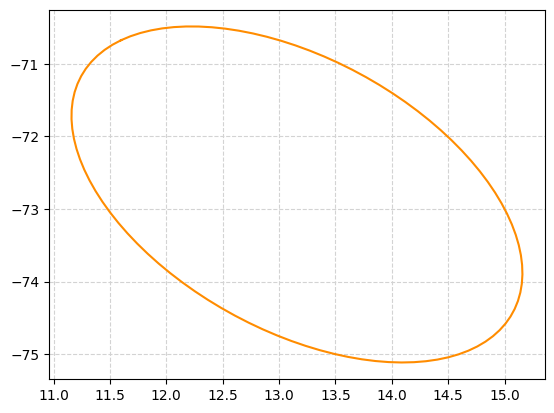

In [119]:
from math import pi, cos, sin, degrees

lmc_ra = SkyCoord.from_name('SMC').ra.value
lmc_dec = SkyCoord.from_name('SMC').dec.value
lmc_maj = 158.113 / 60
lmc_min = 93.105 / 60
lmc_rot = degrees(45)

t = np.linspace(0, 2*pi, 100)
Ell = np.array([lmc_maj*np.cos(t) , lmc_min*np.sin(t)])  
     #u,v removed to keep the same center location
R_rot = np.array([[cos(lmc_rot) , -sin(lmc_rot)],[sin(lmc_rot) , cos(lmc_rot)]])  
     #2-D rotation matrix

Ell_rot = np.zeros((2,Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

#plt.plot( lmc_ra+Ell[0,:] , lmc_dec+Ell[1,:] )     #initial ellipse
plt.plot( lmc_ra+Ell_rot[0,:] , lmc_dec+Ell_rot[1,:],'darkorange' )    #rotated ellipse
plt.grid(color='lightgray',linestyle='--')
plt.show()

In [248]:
from pyongc import ongc

with fits.open('NGC-star-clusters.fits') as hdu:
    header = hdu[1].header
    data = hdu[1].data

clusters_df = pd.DataFrame(data)

# vmags = []
# for s in clusters_df['name']:
#     try:
#         m = ongc.Dso(s).magnitudes[1]
#         vmags.append(m)
#     except:
#         print('No VMag for ', s)
#         vmags.append(None)\

hdu[1]

In [223]:
clusters_list = []
for i in clusters_df['name']:
    clusters_list.append(i)

with open('clusters.fits', 'w') as file:
    data = '\n'.join(clusters_list)
    file.write(data)

In [257]:
clusters_df[77:78]

,name,alt_name,type,ra,dec,radius,pa,ba
77,LMC,,Dwrf,82.5,-69.0,7.0,184.9,0.81
